<font color='b'> <font size=5> ** Introduction ** </font>  
<font color='b'> <font size=2>
 -The data were collected from differents airlines companies and obtained from https://www.transtats.bts.gov/. Theses data had been provided in order to eveluate performances of the differents availables airlines companies. We will use it to define model can allow us to predict the lateness from the provided variables.   
 -Cleaning data.  
 -Features engenering.  
 -Correlation between features.   
 -Independance between qualitative variables with flight delay.</font>

<img src="https://www.ritardoaereo.com/images/layout/logo_en.png"/>

# Importing Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from math import *
from sklearn.preprocessing import LabelEncoder
import seaborn as sns 

# Importing data

The data that we will use,seem too large. Their importation with the whole columns can affect the performance of our machine. So we will present preliminarly list of uselless columns that we will get red of them in order to alleviate data.

In [2]:
col_inutiles=['YEAR','FL_DATE','TAIL_NUM','FL_NUM','ORIGIN_WAC','ORIGIN_AIRPORT_SEQ_ID','UNIQUE_CARRIER','AIRLINE_ID',\
              'ORIGIN_CITY_MARKET_ID','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR','ORIGIN_STATE_FIPS','ORIGIN_STATE_NM',\
              'DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','DEST_CITY_MARKET_ID','DEST_CITY_NAME','DEST_STATE_ABR',\
              'DEST_STATE_FIPS','DEST_STATE_NM','CANCELLATION_CODE','DEST_WAC','FLIGHTS','Unnamed: 64','ORIGIN_AIRPORT_ID']

#list of columns that we judge useless to predict the lateness of flights.

In [3]:
dt=[] # list of the monthly data 
for i in range(1,13):
    if i<10:
       fich='data/2016_0{}.csv'.format(i) 
    else:
       fich='data/2016_{}.csv'.format(i)
    
    l=pd.read_csv(fich,sep=',',error_bad_lines=False)
    for c in col_inutiles: # delete preliminarly useless columns.
        del(l[c])
    dt.append(l)

/home/taher/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 121012: expected 65 fields, saw 75\n'
b'Skipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\n'
b'Skipping line 453858: expected 65 fields, saw 97\n'
/home/taher/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,3,4,10,11,13,19,20,21,22,30,36,41,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data preparation 

<font color='blue'> <font size=3> ** Missing values ** </font>

In [4]:
tab_missing_values=pd.DataFrame({c:sum([dt[i][c].isna().sum() for i in range(12)]) for c in dt[0].columns},index=['missing values'])
#number of missing values for each column.

In [5]:
tab_missing_values # display the missing values table

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
missing values,0,0,0,0,0,0,1,0,63538,63539,...,5,5,4667538,4667538,4667538,4667538,4667538,5601445,5601445,5601445


In [6]:
# for the columns CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY and LATE_AIRCRAFT_DELAY,
#the missing values mean the cause mentionned in the such column hadn't occur for the flight of the such row.
#so we will replace them by zero.
values={'CARRIER_DELAY':0,'WEATHER_DELAY':0,'NAS_DELAY':0,'SECURITY_DELAY':0,'LATE_AIRCRAFT_DELAY':0}
for i in range(12):
   dt[i]=dt[i].fillna(values)

In [7]:
#for the missing values of the columns of departure performances. We will define function that can use the link 
# between these variables in order to replace one missing value when the the other values of equivalent columns
# are available.
def remp_dep(CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK):
    """"This function allow to determinate the exaxtly value of an missing value when equivalent values 
    are available."""
    if pd.isnull(DEP_TIME):
        if not pd.isnull(DEP_DELAY):
           DEP_TIME= CRS_DEP_TIME + DEP_DELAY
        elif not pd.isnull(DEP_DELAY_NEW):
            if DEP_DELAY_NEW > 0:
               DEP_TIME= CRS_DEP_TIME + DEP_DELAY_NEW
        elif not pd.isnull(DEP_TIME_BLK):
           DEP_TIME= DEP_TIME_BLK[5:]
    if pd.isnull(DEP_DELAY):
        if not pd.isnull(DEP_TIME):
           DEP_DELAY= int(DEP_TIME) - int(CRS_DEP_TIME)
        elif not pd.isnull(DEP_DELAY_NEW):
            if DEP_DELAY_NEW > 0:
               DEP_DELAY= DEP_DELAY_NEW
    if pd.isnull(DEP_DELAY_NEW):
        if not pd.isnull(DEP_DELAY):
            if DEP_DELAY > 0:
               DEP_DELAY_NEW= DEP_DELAY
            else:
               DEP_DELAY_NEW=0
    if pd.isnull(DEP_DEL15):
        if not pd.isnull(DEP_DELAY_NEW):
            DEP_DEL15= ceil(DEP_DELAY_NEW/15)
            if DEP_DEL15 > 1:
                DEP_DEL15=0
        elif not pd.isnull(DEP_DELAY_GROUP):
            if DEP_DELAY_GROUP > 0:
                DEP_DEL15=1
            else:
                DEP_DEL15=0
    if pd.isnull(DEP_DELAY_GROUP):
        if not pd.isnull(DEP_DELAY):
            DEP_DELAY_GROUP= ceil(DEP_DELAY/15)
    if pd.isnull(DEP_TIME_BLK):
        if not pd.isnull(DEP_TIME):
           DEP_TIME_BLK= str(CRS_DEP_TIME)+'-'+str(DEP_TIME)
    return(CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK)

In [8]:
for i in range(12):
    dt[i]['DEP_TIME']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[1] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    dt[i]['DEP_DELAY']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[2] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    dt[i]['DEP_DELAY_NEW']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[3] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    dt[i]['DEP_DEL15']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[4] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    dt[i]['DEP_DELAY_GROUP']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[5] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    dt[i]['DEP_TIME_BLK']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[6] for c in zip(dt[i]['CRS_DEP_TIME'],\
                    dt[i]['DEP_TIME'],dt[i]['DEP_DELAY'],dt[i]['DEP_DELAY_NEW'],dt[i]['DEP_DEL15'],\
                    dt[i]['DEP_DELAY_GROUP'],dt[i]['DEP_TIME_BLK'])]
    

In [9]:
# as we had done for departure performance variables ,for the missing values of the columns of arrival performances. 
#We will define also a function that can use the link between these variables in order to replace one missing value
#when the the other values of equivalent columns are available.
def remp_arr(CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK):
    """"This function allow to determinate the exaxtly value of an missing value when equivalent values
    are available."""
    if pd.isnull(CRS_ARR_TIME):
        if not pd.isnull(ARR_TIME):
            if not pd.isnull(ARR_DELAY):
               CRS_ARR_TIME=ARR_TIME-ARR_DELAY
            elif not pd.isnull(ARR_DELAY_NEW):
                if ARR_DELAY_NEW > 0:
                   CRS_ARR_TIME=ARR_TIME-ARR_DELAY_NEW 
    if pd.isnull(ARR_TIME):
        if not pd.isnull(CRS_ARR_TIME):
           if not pd.isnull(ARR_DELAY):
              ARR_TIME= CRS_ARR_TIME + ARR_DELAY
           elif not pd.isnull(ARR_DELAY_NEW):
                if ARR_DELAY_NEW > 0:
                   ARR_TIME= CRS_ARR_TIME + ARR_DELAY_NEW
       
    if pd.isnull(ARR_DELAY):
        if not pd.isnull(CRS_ARR_TIME):
           if not pd.isnull(ARR_TIME):
              ARR_DELAY= int(ARR_TIME) - int(CRS_ARR_TIME)
           elif not pd.isnull(ARR_DELAY_NEW):
              if ARR_DELAY_NEW > 0:
                 ARR_DELAY= ARR_DELAY_NEW
    if pd.isnull(ARR_DELAY_NEW):
        if not pd.isnull(ARR_DELAY):
            if ARR_DELAY > 0:
               ARR_DELAY_NEW= ARR_DELAY
            else:
               ARR_DELAY_NEW=0
    if pd.isnull(ARR_DEL15):
        if not pd.isnull(ARR_DELAY_NEW):
            ARR_DEL15= ceil(ARR_DELAY_NEW/15)
            if ARR_DEL15 > 1:
                ARR_DEL15=0
        elif not pd.isnull(ARR_DELAY_GROUP):
            if ARR_DELAY_GROUP > 0:
                ARR_DEL15=1
            else:
                ARR_DEL15=0
    if pd.isnull(ARR_DELAY_GROUP):
        if not pd.isnull(ARR_DELAY):
            ARR_DELAY_GROUP= ceil(ARR_DELAY/15)
    if pd.isnull(ARR_TIME_BLK):
        if not pd.isnull(ARR_TIME):
            if not pd.isnull(CRS_ARR_TIME):
               ARR_TIME_BLK= str(CRS_ARR_TIME)+'-'+str(ARR_TIME)
    return(CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK)

In [10]:
for i in range(12):
    dt[i]['CRS_ARR_TIME']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[0] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_TIME']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[1] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_DELAY']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[2] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_DELAY_NEW']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[3] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_DEL15']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[4] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_DELAY_GROUP']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[5] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    dt[i]['ARR_TIME_BLK']=[remp_dep(c[0],c[1],c[2],c[3],c[4],c[5],c[6])[6] for c in zip(dt[i]['CRS_ARR_TIME'],\
                    dt[i]['ARR_TIME'],dt[i]['ARR_DELAY'],dt[i]['ARR_DELAY_NEW'],dt[i]['ARR_DEL15'],\
                    dt[i]['ARR_DELAY_GROUP'],dt[i]['ARR_TIME_BLK'])]
    

In [11]:
# for the rest of columns, we will drop all columns which have missing values more than threshold that we will fix 
# to 80%. So we will define hereunder a function which can examinate the percentage of missing values of each 
# column and drop all columns which have missing values more than 80%.

def remplissage(df,seuil):
    ''' This function, examinate each column of the introduced dataframe and eliminate each one who has percentage
        of missing values more than the introduced threshold.
        
        Args:
        dt(DataFrame): a dataframe that the function examinate all his columns.
        seuil(float): threshold upper it the column will be dropped.
        
        Returns:
        df(DataFrame): a dataframe with columns who contains missing values under the introduced threshold.
    '''
    l=len(df)
    
    for c in df.columns :
        cnt=1-((df[c].count())/l)
        if cnt > seuil:
            del(df[c])
    return df

In [12]:
#drop columns which has more than 80% missing values.
for i in range(12):
    dt[i]=remplissage(dt[i],0.8)

In [13]:
tab_missing_values=pd.DataFrame({c:sum([dt[i][c].isna().sum() for i in range(12)]) for c in dt[0].columns},index=['missing values'])

In [14]:
#Display the rest of columns which has missing values yet.
l=[]
for c in tab_missing_values.columns:
    if tab_missing_values.iloc[0][c]> 0:
        l.append(c)
tab_missing_values[l]

,DEST,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP
missing values,1,65523,65523,67983,67983,3,3,3,3,3,3,3,3,4,10,79783,79783,5,5


In [15]:
# As it shown in the table above , we notice that the percentage of rows who contains missing value, represent 
# barely 2% of the whole data. So we decide to drop all rows which contains missing values.
for i in range(12):
    dt[i]=dt[i].dropna()

<font color='blue'> <font size=3> ** Rows duplicated ** </font>

In [16]:
for i in range(12):
    dt[i]=dt[i].drop_duplicates()

<font color='blue'> <font size=3> ** Useless columns ** </font>

In [17]:
# hereunder, we will define a list of columns that we find useless for our goal, which is to predict lateness.
useless_col=['DEP_TIME','DEP_DELAY','DEP_DELAY_NEW','DEP_DEL15','DEP_DELAY_GROUP','DEP_TIME_BLK','TAXI_OUT',\
            'WHEELS_OFF','WHEELS_ON','TAXI_IN','ARR_TIME','ARR_DELAY_NEW','ARR_DEL15','ARR_DELAY_GROUP',\
            'ARR_TIME_BLK','CANCELLED','ACTUAL_ELAPSED_TIME','AIR_TIME','DISTANCE_GROUP','DIVERTED','WEATHER_DELAY'\
            ,'CARRIER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
for i in range(12):
    for c in useless_col:
        del (dt[i][c])




<font color='blue'> <font size=3> ** Data concatenate ** </font>

In [18]:
data=pd.concat(dt) # concatenate the datas of each month datas in one unique dataframe.

In [19]:
data.head() # Survey of the whole data.

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,1,1,6,3,AA,DFW,DTW,1100.0,1438.0,-6.0,158.0,986.0
1,1,1,7,4,AA,DFW,DTW,1100.0,1438.0,-12.0,158.0,986.0
2,1,1,8,5,AA,DFW,DTW,1100.0,1438.0,7.0,158.0,986.0
3,1,1,9,6,AA,DFW,DTW,1100.0,1438.0,-5.0,158.0,986.0
4,1,1,10,7,AA,DFW,DTW,1100.0,1438.0,113.0,158.0,986.0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556195 entries, 0 to 460948
Data columns (total 12 columns):
QUARTER             object
MONTH               int64
DAY_OF_MONTH        object
DAY_OF_WEEK         object
CARRIER             object
ORIGIN              object
DEST                object
CRS_DEP_TIME        float64
CRS_ARR_TIME        float64
ARR_DELAY           float64
CRS_ELAPSED_TIME    float64
DISTANCE            float64
dtypes: float64(5), int64(1), object(6)
memory usage: 551.1+ MB


In [21]:
data['QUARTER']=data['QUARTER'].astype('int')
data['DAY_OF_MONTH']=data['DAY_OF_MONTH'].astype('float')
data['DAY_OF_WEEK']=data['DAY_OF_WEEK'].astype('int')


<font color=blue><font size=3> ** Outliers ** </font>

In [22]:
data['QUARTER'].value_counts()

1    1438728
3    1433721
4    1368626
2    1315120
Name: QUARTER, dtype: int64

In [23]:
data['MONTH'].value_counts()

3     589333
7     491198
8     489965
6     480916
5     475499
10    467486
9     452558
12    452229
11    448911
1     433298
2     416097
4     358705
Name: MONTH, dtype: int64

In [24]:
data['DAY_OF_MONTH'].value_counts()

26.0    187349
15.0    187238
18.0    187204
28.0    186705
22.0    186292
27.0    185545
21.0    185131
14.0    184972
11.0    184833
29.0    184592
19.0    184142
20.0    182979
2.0     182376
12.0    182144
17.0    181472
16.0    181241
13.0    181137
25.0    180947
6.0     180731
1.0     180275
5.0     180088
8.0     180046
23.0    179877
7.0     179511
10.0    178836
3.0     178426
4.0     178298
9.0     178215
24.0    172418
30.0    165138
31.0    108037
Name: DAY_OF_MONTH, dtype: int64

**All the examinated columns above don't present outliers.The rest of columns can take all possibles values.So it is difficult to detecte outliers in theses columns.**

<font color='blue'><font size=3>**Categorical variables**</font>

In [25]:
#Identify the list  of differents companies mentionned in our data set
companies=data['CARRIER'].unique()
companies # display the list companies mentionned in our data set.

array(['AA', 'AS', 'B6', 'DL', 'F9', 'HA', 'NK', 'EV', 'OO', 'UA', 'VX',
       'WN'], dtype=object)

<font color='Citron'>**We will create new variables which correspond to each different airline companie mentionned in our data set and **</font>

In [26]:
# Create new variables correspond to differents airline compagnies mentionned in our dataset on base one hot
#encoding
for c in companies:
    data[c]=[1 if m==c else 0 for m in data['CARRIER']]

In [27]:
#We will know get rid of the column 'CARRIER'.
del(data['CARRIER'])

<font color=blue> <font size=3> ** Features engenering **</font>

**We will create new variables, namely  LATENESS ,risque_or_aeroport and risque_des_aeroport. LATENESS take 1 if the flight make lateness and 0 if it is not. risque_or_aeroport allow to give the number of delayed flight occured in origin aeroport. risque-des_aeroport allow to give the number of delayed flight occured in destinated aeroport.**

In [28]:
#The feature LATENESS take 1 if the value of the feature LATENESS_TIME is strictly positive and 0 if it is not.
data['LATENESS']=[1 if c>0 else 0 for c in data['ARR_DELAY']]

In [29]:
# We will create a new variable which allow to give the numbre of delayed flight occured in origin aeroport.
df=data[data['ARR_DELAY']>0] # data of delayed flight.
aeroport_or=data['ORIGIN'].unique() # data of used aeroport in our data set
tab_nb_retards=pd.DataFrame(index=aeroport_or) # table wich recapitulate the nombre of delayed flight occured in
                                               # each origin aeroport
tab_nb_retards['aeroport_risque']=[len(df[df['ORIGIN']==c]) for c in  aeroport_or]


In [30]:
data['risque_or_aeroport']=[tab_nb_retards.loc[c]['aeroport_risque'] for c in data['ORIGIN']] 
# new variable namely 'risque_or_aeroport' which give the number of delayed flight in origin aeroport for each flight.

In [31]:
# We will create a new variable which allow to give the numbre of delayed flight occured in destinated aeroport.

aeroport_des=data['DEST'].unique() # data of used destinated aeroport in our data set
tab_nb=pd.DataFrame(index=aeroport_des) # table wich recapitulate the nombre of delayed flight occured in
                                               # each destinated aeroport
tab_nb['aeroport_risque']=[len(df[df['DEST']==c]) for c in  aeroport_des]

In [32]:
data['risque_des_aeroport']=[tab_nb.loc[c]['aeroport_risque'] for c in data['DEST']] 
# new variable namely 'risque_or_aeroport' which give the number of delayed flight in origin aeroport for each flight.

In [33]:
data.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,...,HA,NK,EV,OO,UA,VX,WN,LATENESS,risque_or_aeroport,risque_des_aeroport
0,1,1,6.0,3,DFW,DTW,1100.0,1438.0,-6.0,158.0,...,0,0,0,0,0,0,0,0,76937,34317
1,1,1,7.0,4,DFW,DTW,1100.0,1438.0,-12.0,158.0,...,0,0,0,0,0,0,0,0,76937,34317
2,1,1,8.0,5,DFW,DTW,1100.0,1438.0,7.0,158.0,...,0,0,0,0,0,0,0,1,76937,34317
3,1,1,9.0,6,DFW,DTW,1100.0,1438.0,-5.0,158.0,...,0,0,0,0,0,0,0,0,76937,34317
4,1,1,10.0,7,DFW,DTW,1100.0,1438.0,113.0,158.0,...,0,0,0,0,0,0,0,1,76937,34317


<font color=blue> ** Divers Operation ** </font>

In [37]:
data['CRS_DEP_TIME']=[float(c[:2])*60 + float(c[2:]) for c in data['CRS_DEP_TIME'].astype(str)] 
data['CRS_ARR_TIME']=[float(c[:2])*60 + float(c[2:]) for c in data['CRS_ARR_TIME'].astype(str)] 

# Data Exploration

<font color=blue><font size=3> ** Analyse univariate ** </font>

In [40]:
tab=pd.DataFrame({c:[data[c].median(),data[c].mean(),data[c].mode(),data[c].quantile(0.25),\
                    data[c].quantile(0.75)] for c in ['QUARTER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','LATENESS']},\
                index=['median','mean','mode','Q1','Q3'])

In [41]:
tab

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,LATENESS
median,3,7,16,4,0
mean,2.49175,6.51562,15.8206,3.92816,0.340253
mode,0 1 dtype: int64,0 3 dtype: int64,0 26.0 dtype: float64,0 5 dtype: int64,0 0 dtype: int64
Q1,1,3,8,2,0
Q3,3,9,23,6,1


**
-The most flight of the year are in the first quarter especially in the third month.  
-The most flight of the week are in saturday.  
-More than 80% of flight are in time.**

Text(0.5,1,'Histogramme de ARR_DELAY')

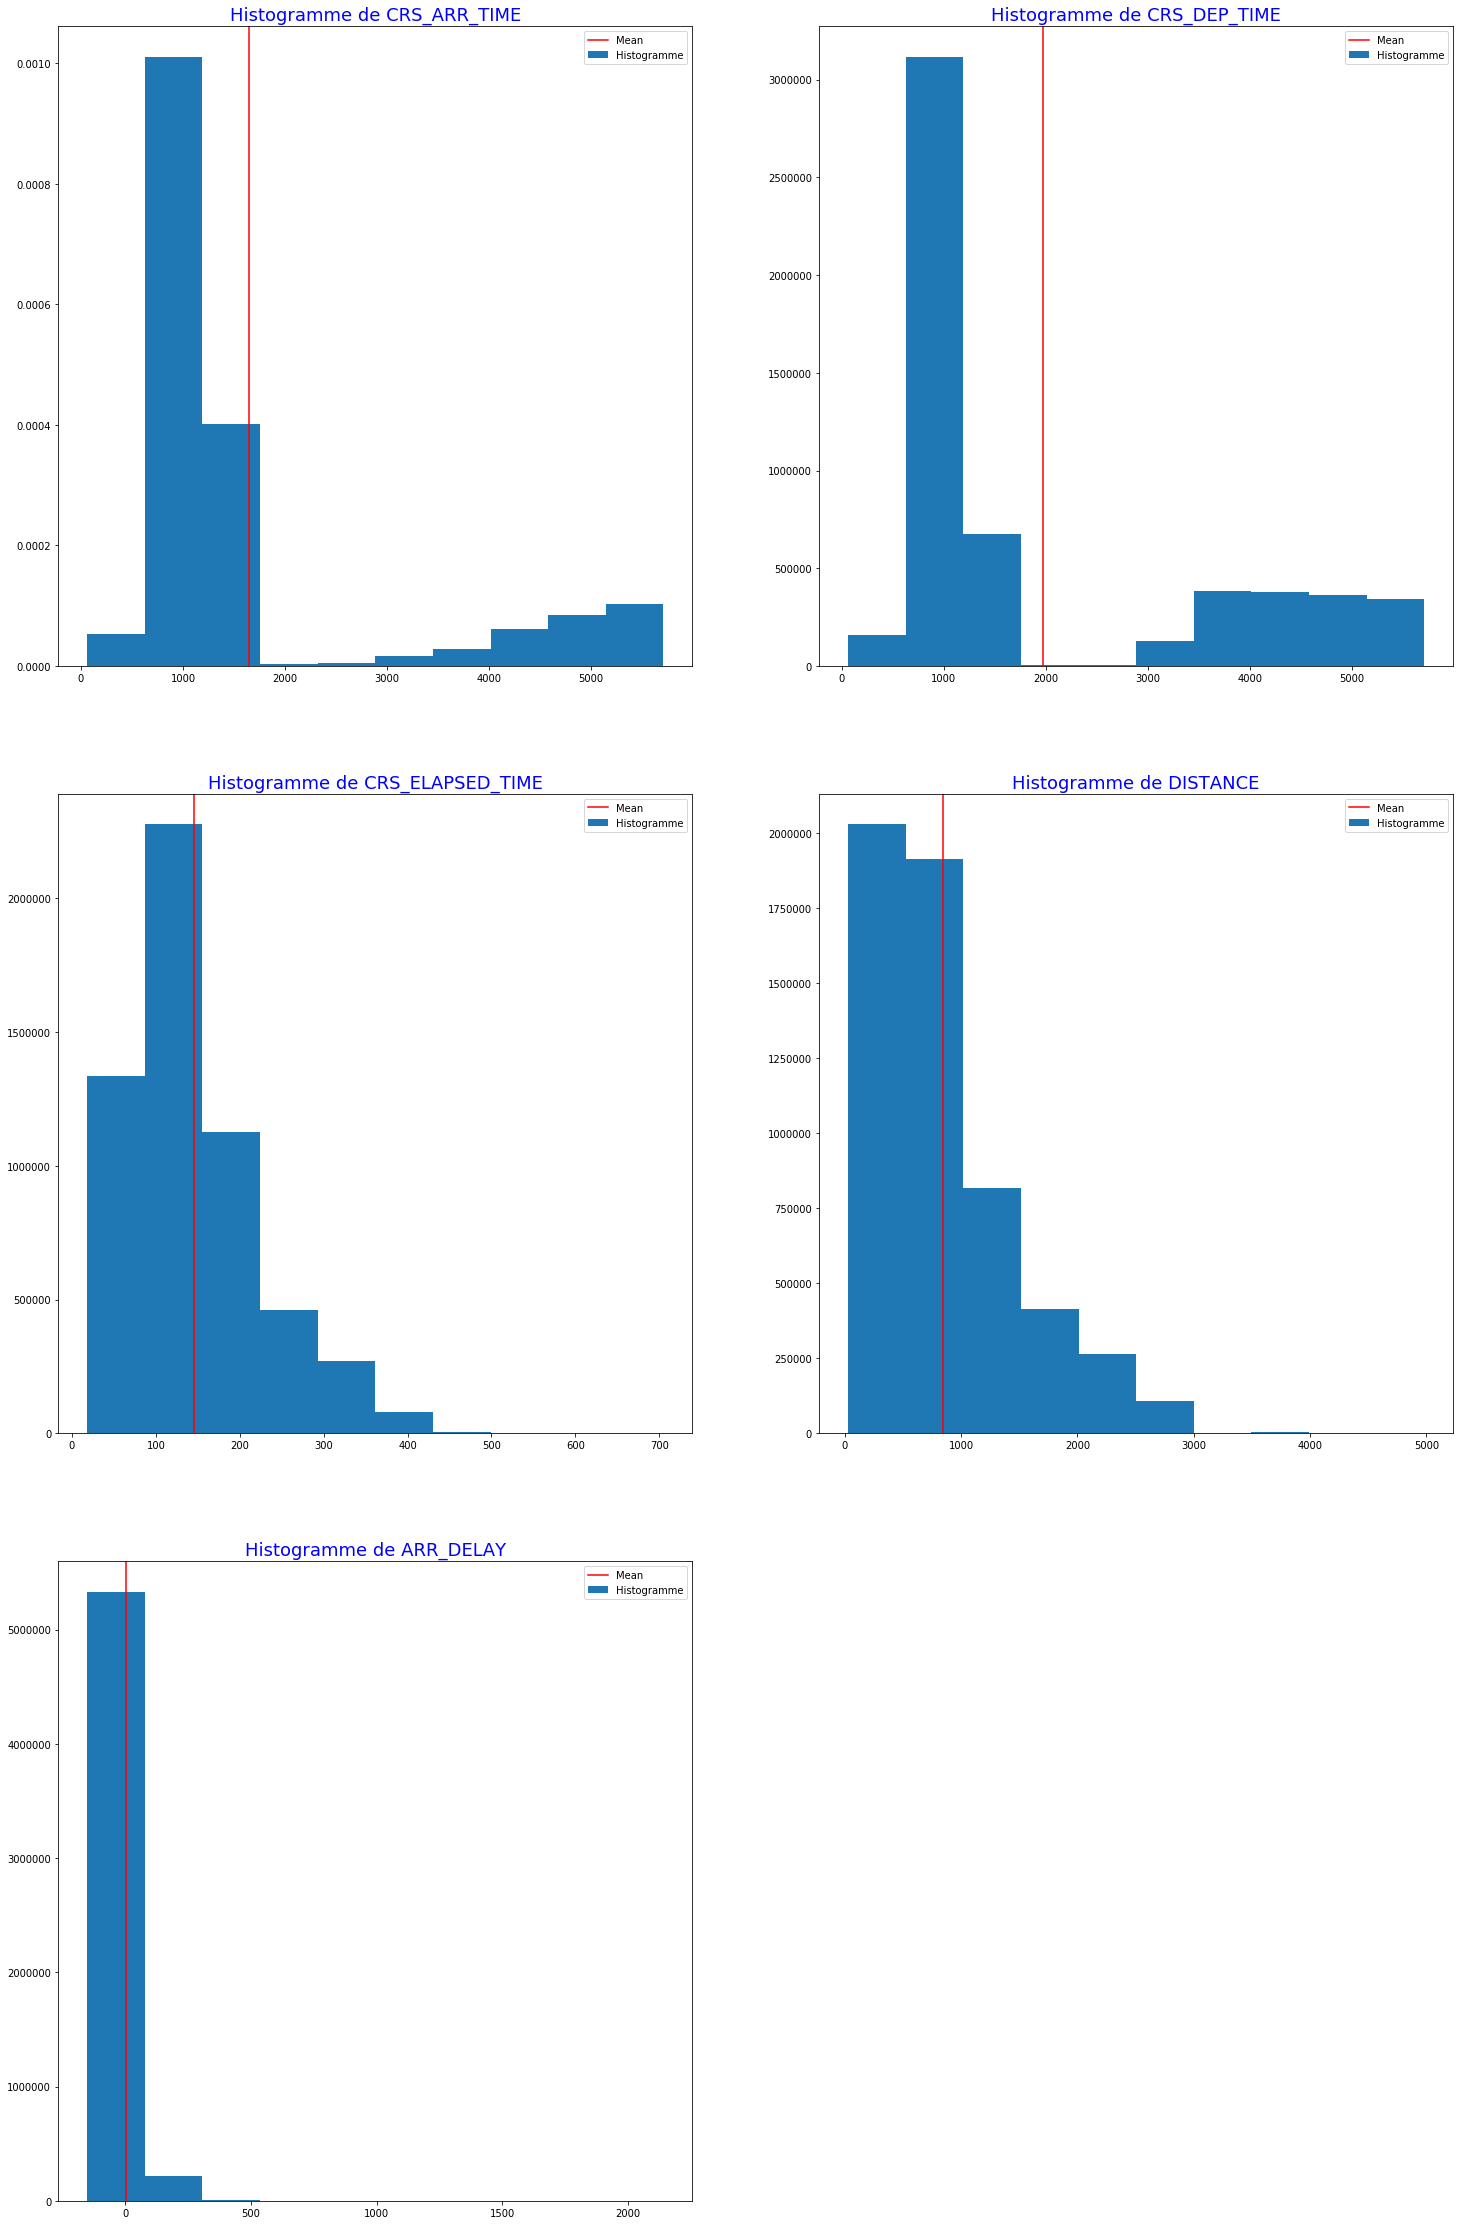

In [42]:
#histogram of differents quantitative variables.
fig=plt.figure(figsize=(25,40))
fig.add_subplot(3,2,1)
plt.hist(data['CRS_ARR_TIME'],density=True,label='Histogramme')
plt.axvline(data['CRS_ARR_TIME'].mean(),color='red',label='Mean')
plt.legend()
plt.title('Histogramme de CRS_ARR_TIME',fontsize=18,color='b')
fig.add_subplot(3,2,2)
plt.hist(data['CRS_DEP_TIME'],label='Histogramme')
plt.axvline(data['CRS_DEP_TIME'].mean(),color='red',label='Mean')
plt.legend()
plt.title('Histogramme de CRS_DEP_TIME',fontsize=18,color='b')
fig.add_subplot(3,2,3)
plt.hist(data['CRS_ELAPSED_TIME'],label='Histogramme')
plt.axvline(data['CRS_ELAPSED_TIME'].mean(),color='red',label='Mean')
plt.legend()
plt.title('Histogramme de CRS_ELAPSED_TIME',fontsize=18,color='b')
fig.add_subplot(3,2,4)
plt.hist(data['DISTANCE'],label='Histogramme')
plt.axvline(data['DISTANCE'].mean(),color='red',label='Mean')
plt.legend()
plt.title('Histogramme de DISTANCE',fontsize=18,color='b')
fig.add_subplot(3,2,5)
plt.hist(data['ARR_DELAY'],label='Histogramme')
plt.axvline(data['ARR_DELAY'].mean(),color='red',label='Mean')
plt.legend()
plt.title('Histogramme de ARR_DELAY',fontsize=18,color='b')

<font color=blue><font size=3> ** Analyse multivriate ** </font>

<font color='green'><font size=2> ** Qualitatives variables ** </font>

<font color='Citron'>** We will try hereunder to  answer the following questions:  
    -Does the number of the late flight depend to the quarter of the year? (Correlation between QUARTER and LATENESS )  
    -Does the number of the late flight depend to the month of the year?( Correlation between MONTH and LATENESS)  
    -Does the number of the late flight depend to the day of the month? (Correlation between DAY_OF_MONTH and LATENESS)  
    -Does the number of the late flight depend to the day of the week ? (Correlation between DAY_OF_WEEK and LATENESS)  
    ** </font>

In [43]:
#to answer the above questions, we need to compute correlation betwen each pair of variables.
#The above variables are qualtitive variables,so we need to compute the contingency table between each pair of variables.
#Thus, we will define function which can display the contingency table and the mesure of correlation between 
# the pair of introduced variables.
def corr_var(var1,var2):
    '''This function, consist to mesure the correlation between the introduced variables and to give the contingency
       table between them.
       
       Args:
       
       var1(Str): the name of the first variable
       var2(str): the name of the second variable
    '''
    X=var1
    Y=var2
    cnt=data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    tx=data[X].value_counts()
    ty=data[Y].value_counts()
    tx=pd.DataFrame(tx)
    ty=pd.DataFrame(ty)
    tx.columns=["values"]
    ty.columns=['values']
    n=len(data)
    ind=tx.dot(ty.T)/n
    mesure=(ind-cnt)**2/ind
    xin=mesure.sum().sum()
    print("Mesure of correlation between the variable {} and the variable {} equal to : {}".format(var1,var2,xin))
    sns.heatmap(mesure,annot=True)
    plt.title('Tableau de contingence entre {} et {}'.format(var1,var2),color='b')
    plt.show()

Mesure of correlation between the variable QUARTER and the variable LATENESS equal to : 4587.045858090962


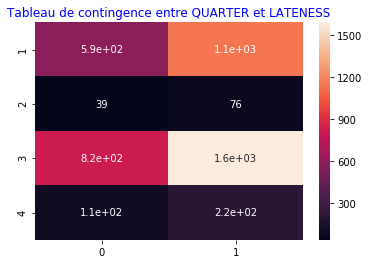

In [44]:
# Correlation between the variable QUARTER and the variable LATENESS.
corr_var('QUARTER','LATENESS')

Mesure of correlation between the variable MONTH and the variable LATENESS equal to : 43168.63559522187


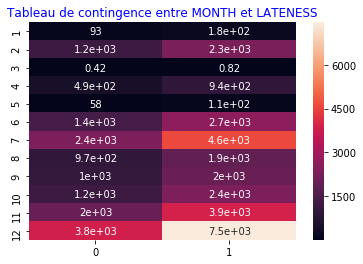

In [45]:
#Correlation between the variable MONTH and the variable LATENESS.
corr_var('MONTH','LATENESS')

Mesure of correlation between the variable DAY_OF_MONTH and the variable LATENESS equal to : 7352.486112732171


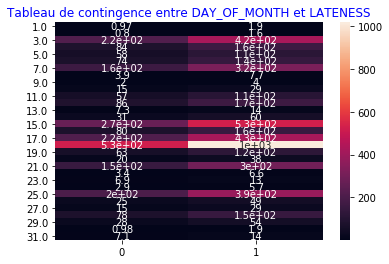

In [46]:
#Correlation between the variable DAY_OF_MONTH and the variable LATENESS.
corr_var('DAY_OF_MONTH','LATENESS')


Mesure of correlation between the variable DAY_OF_WEEK and the variable LATENESS equal to : 14203.934684913165


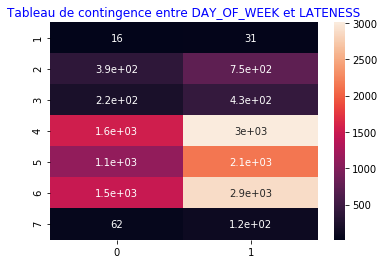

In [47]:
#Correlation between the variable DAY_OF_WEEK and the variable LATENESS.
corr_var('DAY_OF_WEEK','LATENESS')

** The above analyse,allow us to conclude that the late flights depend to the quarter,the month , the day of month, the day of week.It means that the variable LATENESS is not independant to the variables QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK.**   

<font color='green'> <font size=2> ** Quantitatives variables ** </font>

<font color='CITRON'> **Hereunder, we will try to check the correlation between each pair of quantitative variables.**</font> 

In [48]:
table_corr=data[['CRS_DEP_TIME','CRS_ARR_TIME','CRS_ELAPSED_TIME','DISTANCE','risque_or_aeroport'\
                ,'risque_des_aeroport','ARR_DELAY']].corr()
table_corr

,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,risque_or_aeroport,risque_des_aeroport,ARR_DELAY
CRS_DEP_TIME,1.000000,0.421402,0.048069,0.040746,-0.040585,0.048051,-0.074166
CRS_ARR_TIME,0.421402,1.000000,-0.043466,-0.041775,-0.111061,0.097873,-0.045987
CRS_ELAPSED_TIME,0.048069,-0.043466,1.000000,0.984570,0.083340,0.170111,-0.018993
DISTANCE,0.040746,-0.041775,0.984570,1.000000,0.092104,0.127470,-0.015238
risque_or_aeroport,-0.040585,-0.111061,0.083340,0.092104,1.000000,-0.286503,0.018346
risque_des_aeroport,0.048051,0.097873,0.170111,0.127470,-0.286503,1.000000,0.001599
ARR_DELAY,-0.074166,-0.045987,-0.018993,-0.015238,0.018346,0.001599,1.000000


**The above table of correlation, give us the following conclusions:  
    -There is barely no correlation between ARR_DELAY and seperatly the rest of quantitatives variables.  
    -As it is waited, a perfect linear correlation between the variable DISTANCE and CRS_ELAPSED_TIME.  
    -As it is waited, a highly correlation between the variable CRS_DEP_TIME and the variable CRS_ARR_TIME. **
    

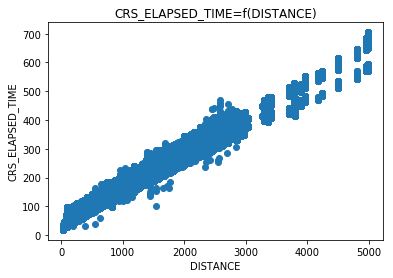

In [49]:
#The visualization of the relation between CRS_ELAPSED_TIME and DISTANCE.
plt.scatter(data['DISTANCE'],data['CRS_ELAPSED_TIME'])
plt.xlabel('DISTANCE')
plt.ylabel('CRS_ELAPSED_TIME')
plt.title('CRS_ELAPSED_TIME=f(DISTANCE)')
plt.show()

Herreunder,we will try to find a linear model which link CRS_ELAPSED_TIME to DISTANCE.

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [51]:
#Linear model links the variable DISTANCE to the variable CRS_ELAPSED_TIME
X=pd.DataFrame({'cte':list(np.ones(len(data))),'d':list(data['DISTANCE'].values)})
Y=data['CRS_ELAPSED_TIME']
Xtr,Xts,Ytr,Yts=train_test_split(X,Y,train_size=0.7)
regressor=LinearRegression(fit_intercept=False)
regressor.fit(Xtr,Ytr)


/home/taher/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [52]:
#Compute the robustness of found model
ypred=regressor.predict(Xts)
print('The robustness of the found model is :{}'.format(sqrt(mean_squared_error(Yts,ypred))))

The robustness of the found model is :13.359346234926594


In [53]:
# Determinate the coefficients of the linear model which link the variable Distance to the variable CRS_ELAPSED_TIME
print('The coefficient of the linear model is {}'.format(regressor.coef_))


The coefficient of the linear model is [42.11256099  0.12151838]


                                CRS_ELAPSED_TIME=42.13+0.12*DISTANCE 

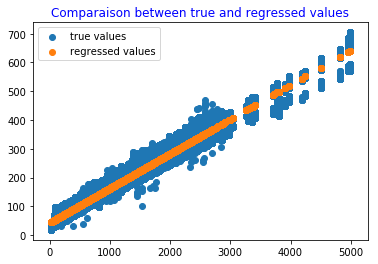

In [54]:
#Comparaison between true and regressed values.
plt.scatter(data['DISTANCE'],data['CRS_ELAPSED_TIME'],label='true values')
plt.scatter(data['DISTANCE'],np.full(len(data),42.13)+0.12*np.array(list(data['DISTANCE'].values)),label='regressed values')
plt.legend()
plt.title('Comparaison between true and regressed values',color='b')
plt.show()

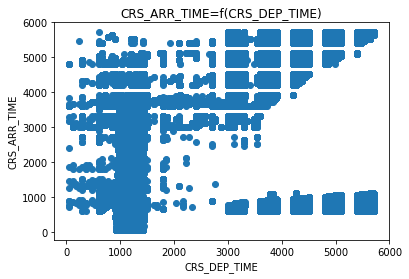

In [55]:
#Visualizing of CRS_ARR_TIME in function to CRS_DEP_TIME.
plt.scatter(data['CRS_DEP_TIME'],data['CRS_ARR_TIME'])
plt.xlabel('CRS_DEP_TIME')
plt.ylabel('CRS_ARR_TIME')
plt.title('CRS_ARR_TIME=f(CRS_DEP_TIME)')
plt.show()

In [56]:
tab_nb.to_csv('arrive_aeroport')

In [57]:
tab_nb_retards.to_csv('origin_aeroport')

In [58]:
del(data['DEST'])
del(data['ORIGIN'])


In [59]:
li=list(data.columns)

In [60]:
li.remove('ARR_DELAY') 
li.remove('LATENESS')

In [61]:
li.append('LATENESS') # put the variable LATENESS and ARR_DELAY in the end of the list
li.append('ARR_DELAY')

In [62]:
data=data[li]

In [63]:
data.head()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,AA,AS,...,NK,EV,OO,UA,VX,WN,risque_or_aeroport,risque_des_aeroport,LATENESS,ARR_DELAY
0,1,1,6.0,3,660.0,878.0,158.0,986.0,1,0,...,0,0,0,0,0,0,76937,34317,0,-6.0
1,1,1,7.0,4,660.0,878.0,158.0,986.0,1,0,...,0,0,0,0,0,0,76937,34317,0,-12.0
2,1,1,8.0,5,660.0,878.0,158.0,986.0,1,0,...,0,0,0,0,0,0,76937,34317,1,7.0
3,1,1,9.0,6,660.0,878.0,158.0,986.0,1,0,...,0,0,0,0,0,0,76937,34317,0,-5.0
4,1,1,10.0,7,660.0,878.0,158.0,986.0,1,0,...,0,0,0,0,0,0,76937,34317,1,113.0


In [64]:
data.to_csv('vols.csv')